In [1]:
#import dependencies 
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wave
import struct
import IPython.display as ipd
import pandas as pd
import librosa
import numpy as np
import librosa.display
from librosa.core import cqt

C:\Users\Usuario\Anaconda3\envs\HeratBeat P 37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\Usuario\Anaconda3\envs\HeratBeat P 37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
F_NAME = 'data/set_a/normal__201101070538.wav'

wav_n = wave.open(F_NAME)

# frames will hold the bytestring representing all the audio frames
frames = wav_n.readframes(-1)
print(frames[:20])
#We need to unpack this bytestring into an array of numbers that we can actually work with.

b'\x0e\x00\x11\x00\x0e\x00\x00\x00\x02\x00\x0b\x00\xfe\xff\x05\x00\x05\x00\x04\x00'


In [3]:
print(wav_n.getsampwidth())
# We multiply it by 8 to get the bit depth. 
# Since the result from the call is 2, that means we're looking at a 16-bit file.

2


In [4]:
samples = struct.unpack('h'*wav_n.getnframes(), frames)
print(samples[:10])

(14, 17, 14, 0, 2, 11, -2, 5, 5, 4)


In [5]:
framerate = wav_n.getframerate()
t = [float(i)/framerate for i in range(len(samples))]
print(t[:10])

[0.0, 2.2675736961451248e-05, 4.5351473922902495e-05, 6.802721088435374e-05, 9.070294784580499e-05, 0.00011337868480725624, 0.00013605442176870748, 0.00015873015873015873, 0.00018140589569160998, 0.00020408163265306123]


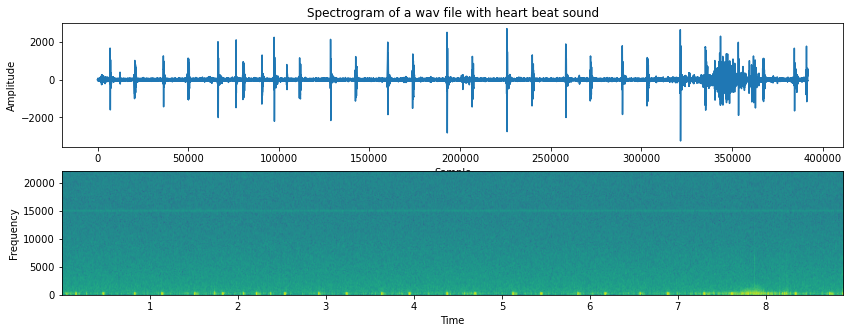

In [6]:
# Read the wav file (mono)
samplingFrequency, signalData = wavfile.read(F_NAME)

# Plot the signal read from wav file
plt.figure(figsize=(14, 5))
plt.subplot(211)
plt.title('Spectrogram of a wav file with heart beat sound')

plt.plot(signalData)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(212)

plt.specgram(signalData,Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()
ipd.display(ipd.Audio(F_NAME, rate=16000))

# Explore data

In [7]:
set_a=pd.read_csv("data/set_a.csv")
set_a_timing=pd.read_csv("data/set_a_timing.csv")
set_b=pd.read_csv("data/set_b.csv")

In [8]:
#merge both set-a and set-b
fullset = [set_a, set_b]
train_ab=pd.concat(fullset)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Btraining_murmur_Btraining_noisymurmur_2...,normal,noisynormal
freq,656,1,351,120


Minimum samples per category =  19
Maximum samples per category =  351


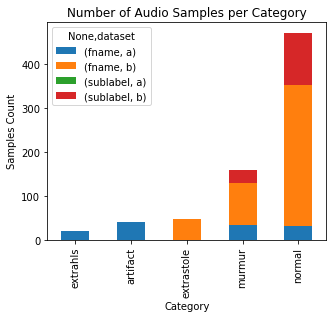

In [9]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(5,4))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

# MFCC

In [12]:
# MFCC of normal heartbeat
y, sr = librosa.load(F_NAME)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-518.2946    -498.763     -486.61652   ... -491.18152   -417.15768
  -400.62518  ]
 [  50.480797    69.88108     80.96759   ...   72.75497    111.06619
   117.573204 ]
 [  -2.6641548    8.817115    15.921576  ...    6.478533    20.60365
    29.337328 ]
 ...
 [  -3.7151346   -7.8375726   -8.347091  ...    1.280344     2.305305
     1.7670501]
 [ -12.113075   -10.746836    -9.509184  ...   -3.9956722   -7.9250836
    -5.974184 ]
 [  -1.4589536   -4.866875    -6.0949926 ...    4.4100714    3.790902
     2.0838027]]


In [11]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-508.58722    -486.3006     -473.39957    ... -479.03748
  -397.97113    -381.89838   ]
 [  39.904118     61.720222     73.54567    ...   64.5112
    99.63705     107.99851   ]
 [   4.03422      15.734038     23.154955   ...   11.2702
    30.53828      38.09884   ]
 ...
 [  -4.992493     -7.61333      -8.489025   ...    0.79134154
     0.8185756     1.0155385 ]
 [  -3.6996343    -9.701344    -10.626077   ...   -0.6086794
    -8.455056     -9.625946  ]
 [   1.4269896    -4.3233414    -9.075687   ...   -1.1071179
    -2.3686893    -2.455781  ]]


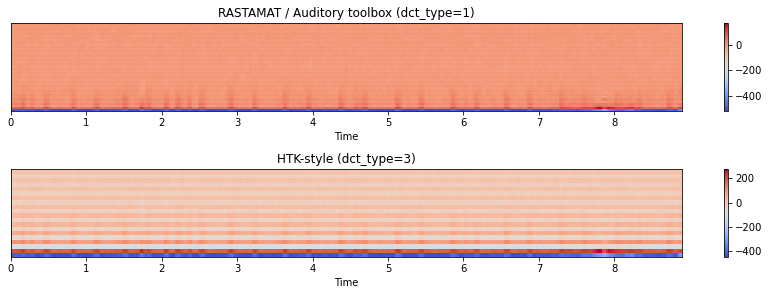

In [12]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=1, n_mfcc=40)

plt.figure(figsize=(12, 6))
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=1)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

# Onset feature

In [11]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))


# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr,aggregate=np.median,fmax=8000, n_mels=256)
plt.plot(times, 1+ (onset_env/onset_env.max()), alpha=0.8,label='Median (custom mel)')

# Constant-Q spectrogram instead of Mel
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.plot(times, onset_env / onset_env.max(), alpha=0.8,label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
#plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
print('Sub-band onset strength')

NameError: name 'y' is not defined

In [14]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

NameError: name 'times' is not defined

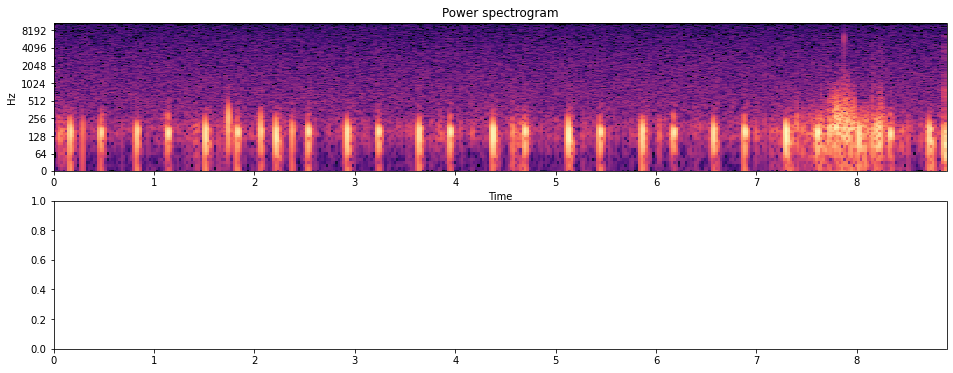

In [13]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

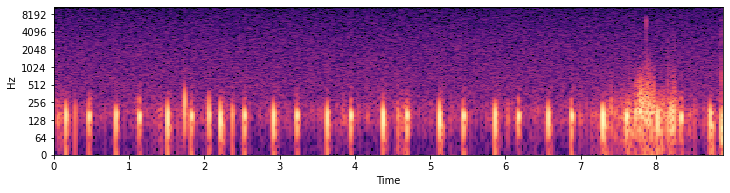

In [20]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig = plt.Figure()
canvas = FigureCanvas(fig)
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')

In [16]:

import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import librosa
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
#import soundfile as sf
import os
import numpy as np
from PIL import Image
from scipy.fftpack import fft

# Paths for audio files and
audio_path_set_a = '../data/set_a/'
imgs_path = '../images/set_a_imgs/'
test_imgs_path = '../images/set_b_imgs/'
audio_path_set_b = '../data/set_b/'
samples = []

def audiotoimage(audio_path, output_image_path):


    for imag_a in audio_path:

        # MFCC of normal heartbeat
        y, sr = librosa.load(imag_a)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)

        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        D = np.abs(librosa.stft(y))
        plt.figure(figsize=(12, 6))
        ax1 = plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', y_axis='log')
        fig.savefig(output_image_path+'.png')
        
audiotoimage(audio_path_set_a, '../images/set_a_imgs/')

PermissionError: [Errno 13] Permission denied: '.'

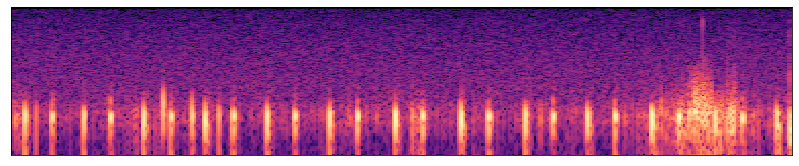

In [54]:
#import dependencies 
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wave
import struct
import IPython.display as ipd
import pandas as pd
import librosa
import numpy as np
import librosa.display
from librosa.core import cqt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

F_NAME = 'data/set_a/normal__201101070538.wav'

dpi = 128 

# MFCC of normal heartbeat
y, sr = librosa.load(F_NAME)

# visualize it
fig = plt.Figure()
#canvas = FigureCanvas(fig)
D = np.abs(librosa.stft(y))
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(2, 1, 1)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', y_axis='log')
plt.savefig('imagetst.png', bbox_inches='tight',pad_inches=0, dpi=dpi)

KeyboardInterrupt: 

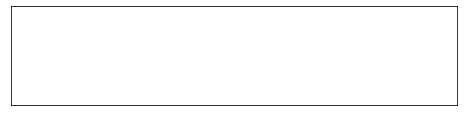

In [80]:
import time

audio_path_set_a = 'data/set_a/'
imgs_path_set_a = 'images/set_a_imgs/'

dpi = 128

for imag_a in glob.glob(audio_path_set_a+'*.wav'):
    for i in os.listdir(audio_path_set_a):
        # MFCC of normal heartbeat
        y, sr = librosa.load(imag_a)

        # visualize it
        fig = plt.Figure()
        #canvas = FigureCanvas(fig)
        D = np.abs(librosa.stft(y))
        plt.figure(figsize=(8, 4))
        ax1 = plt.subplot(2, 1, 1)
        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', y_axis='log')
        plt.savefig(imgs_path_set_a+i.split('.')[0]+'.png', bbox_inches='tight',pad_inches=0, dpi=dpi)
        time.sleep(1)
        plt.close()

In [77]:
audio_path_set_a = 'data/set_a/'
imgs_path_set_a = 'images/set_a_imgs/'

for imag_a in glob.glob(audio_path_set_a+'*.wav'):
    for i in os.listdir(audio_path_set_a):
        print(imgs_path_set_a+i.split('.')[0]+'.png')

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

images/set_a_imgs/murmur__201101180902.png
images/set_a_imgs/murmur__201102051443.png
images/set_a_imgs/murmur__201102052338.png
images/set_a_imgs/murmur__201103291548.png
images/set_a_imgs/murmur__201104021355.png
images/set_a_imgs/murmur__201104241315.png
images/set_a_imgs/murmur__201104291843.png
images/set_a_imgs/murmur__201106141148.png
images/set_a_imgs/murmur__201108222221.png
images/set_a_imgs/murmur__201108222223.png
images/set_a_imgs/murmur__201108222224.png
images/set_a_imgs/murmur__201108222226.png
images/set_a_imgs/murmur__201108222227.png
images/set_a_imgs/murmur__201108222231.png
images/set_a_imgs/murmur__201108222232.png
images/set_a_imgs/murmur__201108222233.png
images/set_a_imgs/murmur__201108222235.png
images/set_a_imgs/murmur__201108222236.png
images/set_a_imgs/murmur__201108222237.png
images/set_a_imgs/murmur__201108222238.png
images/set_a_imgs/murmur__201108222242.png
images/set_a_imgs/murmur__201108222243.png
images/set_a_imgs/murmur__201108222245.png
images/set_

images/set_a_imgs/normal__201102201230.png
images/set_a_imgs/normal__201102260502.png
images/set_a_imgs/normal__201102270940.png
images/set_a_imgs/normal__201103090635.png
images/set_a_imgs/normal__201103101140.png
images/set_a_imgs/normal__201103140132.png
images/set_a_imgs/normal__201103140135.png
images/set_a_imgs/normal__201103140822.png
images/set_a_imgs/normal__201103151912.png
images/set_a_imgs/normal__201103170121.png
images/set_a_imgs/normal__201103221214.png
images/set_a_imgs/normal__201104122156.png
images/set_a_imgs/normal__201104141251.png
images/set_a_imgs/normal__201105011626.png
images/set_a_imgs/normal__201105021654.png
images/set_a_imgs/normal__201105021804.png
images/set_a_imgs/normal__201105151450.png
images/set_a_imgs/normal__201106111136.png
images/set_a_imgs/normal__201106141148.png
images/set_a_imgs/normal__201106151236.png
images/set_a_imgs/normal__201106210943.png
images/set_a_imgs/normal__201106221418.png
images/set_a_imgs/normal__201106221450.png
images/set_

images/set_a_imgs/artifact__201106211041.png
images/set_a_imgs/artifact__201106211430.png
images/set_a_imgs/artifact__201106212112.png
images/set_a_imgs/artifact__201106220340.png
images/set_a_imgs/artifact__201106221254.png
images/set_a_imgs/Aunlabelledtest__201012172010.png
images/set_a_imgs/Aunlabelledtest__201101051105.png
images/set_a_imgs/Aunlabelledtest__201101061552.png
images/set_a_imgs/Aunlabelledtest__201101091156.png
images/set_a_imgs/Aunlabelledtest__201101110659.png
images/set_a_imgs/Aunlabelledtest__201101152256.png
images/set_a_imgs/Aunlabelledtest__201101220549.png
images/set_a_imgs/Aunlabelledtest__201101241434.png
images/set_a_imgs/Aunlabelledtest__201102081033.png
images/set_a_imgs/Aunlabelledtest__201102081045.png
images/set_a_imgs/Aunlabelledtest__201102200848.png
images/set_a_imgs/Aunlabelledtest__201103011036.png
images/set_a_imgs/Aunlabelledtest__201103140236.png
images/set_a_imgs/Aunlabelledtest__201103170122.png
images/set_a_imgs/Aunlabelledtest__201103200518

images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set_a_imgs/artifact__201106101955.png
images/set_a_imgs/artifact__201106110909.png
images/set_a_imgs/artifact__201106111119.png
images/set_a_imgs/artifact__201106121242.png
images/set_a_imgs/artifact__201106121445.png
images/set_a_imgs/artifact__201106131834.png
images/set_a_imgs/artifact__201106131835.png
images/set

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

images/set_a_imgs/Aunlabelledtest__201108222241.png
images/set_a_imgs/Aunlabelledtest__201108222244.png
images/set_a_imgs/Aunlabelledtest__201108222247.png
images/set_a_imgs/Aunlabelledtest__201108222254.png
images/set_a_imgs/Aunlabelledtest__201108222257.png
images/set_a_imgs/extrahls__201101070953.png
images/set_a_imgs/extrahls__201101091153.png
images/set_a_imgs/extrahls__201101152255.png
images/set_a_imgs/extrahls__201101160804.png
images/set_a_imgs/extrahls__201101160808.png
images/set_a_imgs/extrahls__201101161027.png
images/set_a_imgs/extrahls__201101241423.png
images/set_a_imgs/extrahls__201101241433.png
images/set_a_imgs/extrahls__201102070251.png
images/set_a_imgs/extrahls__201102071835.png
images/set_a_imgs/extrahls__201102241217.png
images/set_a_imgs/extrahls__201103150114.png
images/set_a_imgs/extrahls__201103170134.png
images/set_a_imgs/extrahls__201103182227.png
images/set_a_imgs/extrahls__201103200218.png
images/set_a_imgs/extrahls__201104021355.png
images/set_a_imgs/ex

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

images/set_a_imgs/murmur__201108222235.png
images/set_a_imgs/murmur__201108222236.png
images/set_a_imgs/murmur__201108222237.png
images/set_a_imgs/murmur__201108222238.png
images/set_a_imgs/murmur__201108222242.png
images/set_a_imgs/murmur__201108222243.png
images/set_a_imgs/murmur__201108222245.png
images/set_a_imgs/murmur__201108222246.png
images/set_a_imgs/murmur__201108222248.png
images/set_a_imgs/murmur__201108222251.png
images/set_a_imgs/murmur__201108222252.png
images/set_a_imgs/murmur__201108222253.png
images/set_a_imgs/murmur__201108222255.png
images/set_a_imgs/murmur__201108222256.png
images/set_a_imgs/murmur__201108222258.png
images/set_a_imgs/normal__201101070538.png
images/set_a_imgs/normal__201101151127.png
images/set_a_imgs/normal__201102081152.png
images/set_a_imgs/normal__201102081321.png
images/set_a_imgs/normal__201102201230.png
images/set_a_imgs/normal__201102260502.png
images/set_a_imgs/normal__201102270940.png
images/set_a_imgs/normal__201103090635.png
images/set_

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

images/set_a_imgs/artifact__201012172012.png
images/set_a_imgs/artifact__201105040918.png
images/set_a_imgs/artifact__201105041959.png
images/set_a_imgs/artifact__201105051017.png
images/set_a_imgs/artifact__201105060108.png
images/set_a_imgs/artifact__201105061143.png
images/set_a_imgs/artifact__201105190800.png
images/set_a_imgs/artifact__201105280851.png
images/set_a_imgs/artifact__201106010559.png
images/set_a_imgs/artifact__201106010602.png
images/set_a_imgs/artifact__201106021541.png
images/set_a_imgs/artifact__201106030612.png
images/set_a_imgs/artifact__201106031558.png
images/set_a_imgs/artifact__201106040722.png
images/set_a_imgs/artifact__201106040933.png
images/set_a_imgs/artifact__201106040947.png
images/set_a_imgs/artifact__201106041452.png
images/set_a_imgs/artifact__201106050353.png
images/set_a_imgs/artifact__201106061233.png
images/set_a_imgs/artifact__201106070537.png
images/set_a_imgs/artifact__201106070949.png
images/set_a_imgs/artifact__201106101314.png
images/set

In [74]:
for os.listdir(audio_path_set_a)

['artifact__201012172012.wav',
 'artifact__201105040918.wav',
 'artifact__201105041959.wav',
 'artifact__201105051017.wav',
 'artifact__201105060108.wav',
 'artifact__201105061143.wav',
 'artifact__201105190800.wav',
 'artifact__201105280851.wav',
 'artifact__201106010559.wav',
 'artifact__201106010602.wav',
 'artifact__201106021541.wav',
 'artifact__201106030612.wav',
 'artifact__201106031558.wav',
 'artifact__201106040722.wav',
 'artifact__201106040933.wav',
 'artifact__201106040947.wav',
 'artifact__201106041452.wav',
 'artifact__201106050353.wav',
 'artifact__201106061233.wav',
 'artifact__201106070537.wav',
 'artifact__201106070949.wav',
 'artifact__201106101314.wav',
 'artifact__201106101955.wav',
 'artifact__201106110909.wav',
 'artifact__201106111119.wav',
 'artifact__201106121242.wav',
 'artifact__201106121445.wav',
 'artifact__201106131834.wav',
 'artifact__201106131835.wav',
 'artifact__201106141701.wav',
 'artifact__201106161016.wav',
 'artifact__201106161019.wav',
 'artifa